In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.model_selection import train_test_split

from seiz_eeg.dataset import EEGDataset

# The data

We model *segments* of brain activity, which correspond to windows of a longer *session* of EEG recording.

These segments, and their labels, are described in the `segments.parquet` files, which can be directly loaded with `pandas`.

In [ ]:
# You might need to change this according to where you store the data folder
# Inside your data folder, you should have the following structure:
# data
# ├── train
# │   ├── signals/
# │   ├── segments.parquet
# │-- test
#     ├── signals/
#     ├── segments.parquet

data_path = "../data"

DATA_ROOT = Path(data_path)
clips_tr = pd.read_parquet(DATA_ROOT / "train/segments.parquet")

# Split the dataset by the 'patient' column
patients = clips_tr['signals_path'].unique()
train_patients, val_patients = train_test_split(patients, test_size=0.2, random_state=42)

# Create training and validation datasets
train_clips = clips_tr[clips_tr['signals_path'].isin(train_patients)]
val_clips = clips_tr[clips_tr['signals_path'].isin(val_patients)]

## Loading the signals

For convenience, the `EEGDataset class` provides functionality for loading each segment and its label as `numpy` arrays.

You can provide an optional `signal_transform` function to preprocess the signals. In the example below, we have two bandpass filtering functions, which extract frequencies between 0.5Hz and 30Hz which are used in seizure analysis literature:

The `EEGDataset` class also allows to load all data in memory, instead of reading it from disk at every iteration. If your compute allows it, you can use `prefetch=True`.

In [3]:
bp_filter = signal.butter(4, (0.5, 30), btype="bandpass", output="sos", fs=250)


def time_filtering(x: np.ndarray) -> np.ndarray:
    """Filter signal in the time domain"""
    return signal.sosfiltfilt(bp_filter, x, axis=0).copy()


def fft_filtering(x: np.ndarray) -> np.ndarray:
    """Compute FFT and only keep"""
    x = np.abs(np.fft.fft(x, axis=0))
    x = np.log(np.where(x > 1e-8, x, 1e-8))

    win_len = x.shape[0]
    # Only frequencies b/w 0.5 and 30Hz
    return x[int(0.5 * win_len // 250) : 30 * win_len // 250]

## Compatibility with PyTorch

The `EEGDataset` class is compatible with [pytorch datasets and dataloaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html), which allow you to load batched data.

In [4]:
# Dependences
import os
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from tqdm import tqdm

In [5]:
def seed_everything(seed: int):
    # Python random module
    random.seed(seed)
    # Numpy random module
    np.random.seed(seed)
    # Torch random seeds
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.

    # Set PYTHONHASHSEED environment variable for hash-based operations
    os.environ["PYTHONHASHSEED"] = str(seed)

    # Ensure deterministic behavior in cudnn (may slow down your training)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(1)

In [6]:
train_dataset = EEGDataset(
        train_clips,
        signals_root=DATA_ROOT / "train",
        signal_transform=time_filtering,
        prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
    )

val_dataset = EEGDataset(
        val_clips,
        signals_root=DATA_ROOT / "train",
        signal_transform=time_filtering,
        prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
    )

loader_tr = DataLoader(
        dataset=train_dataset,
        shuffle=True,
        batch_size=512,
    )

loader_val = DataLoader(
        dataset=val_dataset,
        shuffle=True,
        batch_size=512,
    )

## Transformer

In this section, we implement a simple transformer model.

In [7]:
class EEGPatchEmbedding(nn.Module):
    def __init__(self, patch_size=50, stride=25, in_channels=19, signal_len=3000, emb_dim=128):
        super().__init__()
        self.patch_size = patch_size
        self.stride = stride
        self.emb_dim = emb_dim

        # Calculate number of patches per channel
        self.num_patches_per_channel = 1 + (signal_len - patch_size) // stride
        self.total_patches = self.num_patches_per_channel * in_channels

        # Linear projection of flattened patch
        self.proj = nn.Linear(patch_size, emb_dim)
        self.pos_embed = nn.Parameter(torch.randn(1, self.total_patches, emb_dim))

    def forward(self, x):
        # x: (batch_size, 3000, 19)
        b, t, c = x.shape
        patches = []

        for ch in range(c):
            # Sliding window on each channel
            ch_seq = x[:, :, ch]  # (batch, 3000)
            ch_patches = ch_seq.unfold(1, self.patch_size, self.stride)  # (batch, num_patches, patch_size)
            patches.append(ch_patches)

        x_patches = torch.cat(patches, dim=1)  # (batch, total_patches, patch_size)
        x_embed = self.proj(x_patches) + self.pos_embed  # (batch, total_patches, emb_dim)
        return x_embed


class TransformerEncoderBlock(nn.Module):
    def __init__(self, emb_dim=128, n_heads=4, dropout=0.1, ff_hidden=256):
        super().__init__()
        self.attn = nn.MultiheadAttention(emb_dim, n_heads, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(emb_dim)
        self.ff = nn.Sequential(
            nn.Linear(emb_dim, ff_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(ff_hidden, emb_dim)
        )
        self.norm2 = nn.LayerNorm(emb_dim)

    def forward(self, x):
        # x: (batch, seq_len, emb_dim)
        attn_output, _ = self.attn(x, x, x)
        x = self.norm1(x + attn_output)
        ff_output = self.ff(x)
        x = self.norm2(x + ff_output)
        return x


class EEGTransformerClassifier(nn.Module):
    def __init__(self, in_channels=19, signal_len=3000, patch_size=50, stride=25,
                 emb_dim=128, num_layers=4, n_heads=4, dropout=0.1, num_classes=1):
        super().__init__()
        self.embedding = EEGPatchEmbedding(patch_size, stride, in_channels, signal_len, emb_dim)
        self.encoder = nn.Sequential(*[
            TransformerEncoderBlock(emb_dim, n_heads, dropout) for _ in range(num_layers)
        ])
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Linear(emb_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        # x: (batch_size, 19, 3000)
        x = self.embedding(x)  # (batch, seq_len, emb_dim)
        x = self.encoder(x)    # (batch, seq_len, emb_dim)
        x = x.transpose(1, 2)  # for pooling: (batch, emb_dim, seq_len)
        x = self.pool(x).squeeze(-1)  # (batch, emb_dim)
        x = self.classifier(x)       # (batch, 1) or (batch, num_classes)
        return x


In [8]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [9]:
# Instantiate model, loss, and optimizer, then move model to device
model = EEGTransformerClassifier(emb_dim=32, num_layers=2, patch_size=200, stride=100).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [10]:
# Count the total number of parameters in the model
total_params = sum(p.numel() for p in model.parameters())

# Count only trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 68289
Trainable parameters: 68289


In [11]:
from sklearn.metrics import f1_score

# Training loop
num_epochs = 100
train_losses = []
val_losses = []
val_f1_scores = []

for epoch in tqdm(range(num_epochs), desc="Training"):
    model.train()
    running_loss = 0.0

    for x_batch, y_batch in loader_tr:
        # Move data to GPU (if available)
        x_batch = x_batch.float().to(device)  # [batch_size, seq_len, input_dim]
        y_batch = y_batch.float().unsqueeze(1).to(device)  # [batch_size, 1]

        # Forward pass
        logits = model(x_batch)
        loss = criterion(logits, y_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(loader_tr)
    train_losses.append(avg_loss)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for x_val, y_val in loader_val:
            # Move data to GPU (if available)
            x_val = x_val.float().to(device)  # [batch_size, seq_len, input_dim]
            y_val = y_val.float().unsqueeze(1).to(device)  # [batch_size, 1]

            # Forward pass
            val_logits = model(x_val)
            val_probs = torch.sigmoid(val_logits)  # Apply sigmoid for binary classification
            val_preds = (val_probs > 0.5).int()  # Convert probabilities to binary predictions

            # Collect all labels and predictions
            all_labels.extend(y_val.cpu().numpy())
            all_preds.extend(val_preds.cpu().numpy())

            # Compute validation loss
            val_loss = criterion(val_logits, y_val)
            val_running_loss += val_loss.item()

    avg_val_loss = val_running_loss / len(loader_val)
    val_losses.append(avg_val_loss)

    # Compute F1 score for validation data
    val_f1 = f1_score(all_labels, all_preds, average='binary')  # Use 'binary' for binary classification
    val_f1_scores.append(val_f1)

Training: 100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [11:30<00:00,  6.90s/it]


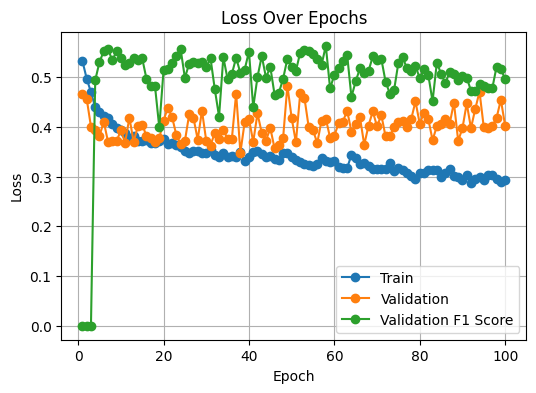

In [12]:
# Plot the training loss
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(range(1, num_epochs + 1), train_losses, marker="o")
plt.plot(range(1, num_epochs + 1), val_losses, marker="o")
plt.plot(range(1, num_epochs + 1), val_f1_scores, marker="o")
plt.title("Loss Over Epochs")
plt.legend(["Train", "Validation", "Validation F1 Score"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [13]:
from evaluation import evaluate

evaluate(
    EEGTransformerClassifier,
    clips_tr,
    signals_root=DATA_ROOT / "train",
    num_epochs=1000,
    learning_rate=1e-3,
    model_args={},
    signal_transform=fft_filtering,
    batch_size=512,
    prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
)

Fold 1/5


RuntimeError: The size of tensor a (247) must match the size of tensor b (2261) at non-singleton dimension 1

# Submission

In [ ]:
test_clips = pd.read_parquet(DATA_ROOT / "test/segments.parquet")

In [ ]:
# Create test dataset
dataset_te = EEGDataset(
    test_clips,  # Your test clips variable
    signals_root=DATA_ROOT
    / "test",  # Update this path if your test signals are stored elsewhere
    signal_transform=fft_filtering,  # You can change or remove the signal_transform as needed
    prefetch=True,  # Set to False if prefetching causes memory issues on your compute environment
    return_id=True,  # Return the id of each sample instead of the label
)

# Create DataLoader for the test dataset
loader_te = DataLoader(dataset_te, batch_size=512, shuffle=False)

In [ ]:
# Generate the submission file for Kaggle

# Set the model to evaluation mode
model.eval()

# Lists to store sample IDs and predictions
all_predictions = []
all_ids = []

# Disable gradient computation for inference
with torch.no_grad():
    for batch in loader_te:
        # Assume each batch returns a tuple (x_batch, sample_id)
        # If your dataset does not provide IDs, you can generate them based on the batch index.
        x_batch, x_ids = batch

        # Move the input data to the device (GPU or CPU)
        x_batch = x_batch.float().to(device)

        # Perform the forward pass to get the model's output logits
        logits = model(x_batch)

        # Convert logits to predictions.
        # For binary classification, threshold logits at 0 (adjust this if you use softmax or multi-class).
        predictions = (logits > 0).int().cpu().numpy()

        # Append predictions and corresponding IDs to the lists
        all_predictions.extend(predictions.flatten().tolist())
        all_ids.extend(list(x_ids))

# Create a DataFrame for Kaggle submission with the required format: "id,label"
submission_df = pd.DataFrame({"id": all_ids, "label": all_predictions})

# Save the DataFrame to a CSV file without an index
submission_df.to_csv("submission_seed1.csv", index=False)
print("Kaggle submission file generated: submission.csv")

Kaggle submission file generated: submission.csv
